<a href="https://colab.research.google.com/github/EEESlab/APAI24-LAB03-DNN-Shrinking-and-Quantization/blob/master/APAI24-LAB03-DNN-Shrinking-and-Quantization.ipynb" 
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LAB03 APAI: DNN shrinking & quantization**

**Credits**: *Davide Nadalini, Lorenzo Lamberti, Luca Bompani, Alberto Dequino, Francesco Conti*.
*(University of Bologna)*

**Contacts**: lorenzo.lamberti@unibo.it,    d.nadalini@unibo.it,    alberto.dequino@unibo.it,   luca.bompani5@unibo.it

## **In this Hands-on session:**

A first-time user of Pytorch framework will learn how to quantize a CNN and how to visualize its graph

### Tasks:

---

1. Load model’s trained weights of LAB1;
2. Reduce network’s size under 5MMAC;
3. Re-train the reduced network and verify network’s accuracy;
4. quantize with QuantLab;
5. Export Onnx and analyze the float32 and quantized models with Netron.

---





⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️ **IMPORTANT**\: ⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️

Before staring, we need to install some prerequisites for quantlab.
Follow these instructions:
1. set the runtime hardware accelerator to *GPU* (use the menu **Runtime > Change runtime type > Hardware accelerator**);
2. run the cell below this one; do NOT run the cells that follow it;
3. restart the runtime (use the menu **Runtime > Restart runtime**);
4. run the remaining cells of the notebook; do NOT run the cell below this one.



In [ ]:
%%capture

# #@title Install dependencies { form-width: "20%" }

# these ones should already be available
!pip install numpy
!pip install tqdm
!pip install pillow

!pip install torch
!pip install torchvision

!pip install thop
!pip install matplotlib
!pip install scikit-learn
!pip install torchinfo

# You will need these if running on a private server (no colab)
# !pip install jupyter
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

# QuantLab
!pip install onnx
!rm -rf quantlab; git clone https://github.com/pulp-platform/quantlab.git
!cd quantlab; rm -rf quantlib; git clone https://github.com/pulp-platform/quantlib.git; cd quantlib; git checkout bff535
!cd quantlab/quantlib; python setup.py install

## **Let's start !**

## Imports:
Now we import some packages  we will need:

In [ ]:
#basic
import os
from os.path import join
import numpy as np
from tqdm import tqdm
import time

#plotting
import matplotlib.pyplot as plt

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

#torchvision
import torchvision
from torchvision import transforms, datasets

# others
from copy import deepcopy
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
from collections import defaultdict

# QuantLab
import quantlib
import quantlib.editing.lightweight as qlw
import quantlib.algorithms as qa
import quantlib.backends as qb
from typing import Union, Tuple, List, Dict


## Set device
Between "cuda" and "cpu"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

# **Recap LAB1**
All of this section is just used to bring in all the code we wrote in previous Lab.

## **From LAB1 Task1:** Creating a Model
---



Let's define again the NN topology from LAB1:

In [ ]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ConvBnRelu, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False, padding_mode='zeros')
        self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

class CNN(nn.Module):
    def __init__(self, n_classes=10, depth_mult=1.):
        super(CNN, self).__init__()
        # first_conv_channels=int(32*depth_mult)
        self.ConvBnRelu1 = ConvBnRelu(1, 32,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.ConvBnRelu2 = ConvBnRelu(32, 64,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False) # MaxPool2: in=14x14, out=14x14/2
        self.ConvBnRelu3 = ConvBnRelu(64, 128, stride=2) # conv3x3: ch_in=32, ch_out=64, in=7x7, out=7x7
        self.dropout = nn.Dropout(p=0.5, inplace=False)
        fc_in_size = 7*7*128
        self.fc = nn.Linear(fc_in_size, n_classes, bias=False)
        # self.softmax = nn.LogSoftmax(dim=1) # we remove it because the quantization tool (Quantlab) does not handle it

    def forward(self, x):
        x = self.ConvBnRelu1(x)
        x = self.ConvBnRelu2(x)
        x = self.pool(x)
        x = self.ConvBnRelu3(x)
        x = self.dropout(x)
        x = x.flatten(1)
        output = self.fc(x)
        # output = self.softmax(x)
        return output

net = CNN().to(device)


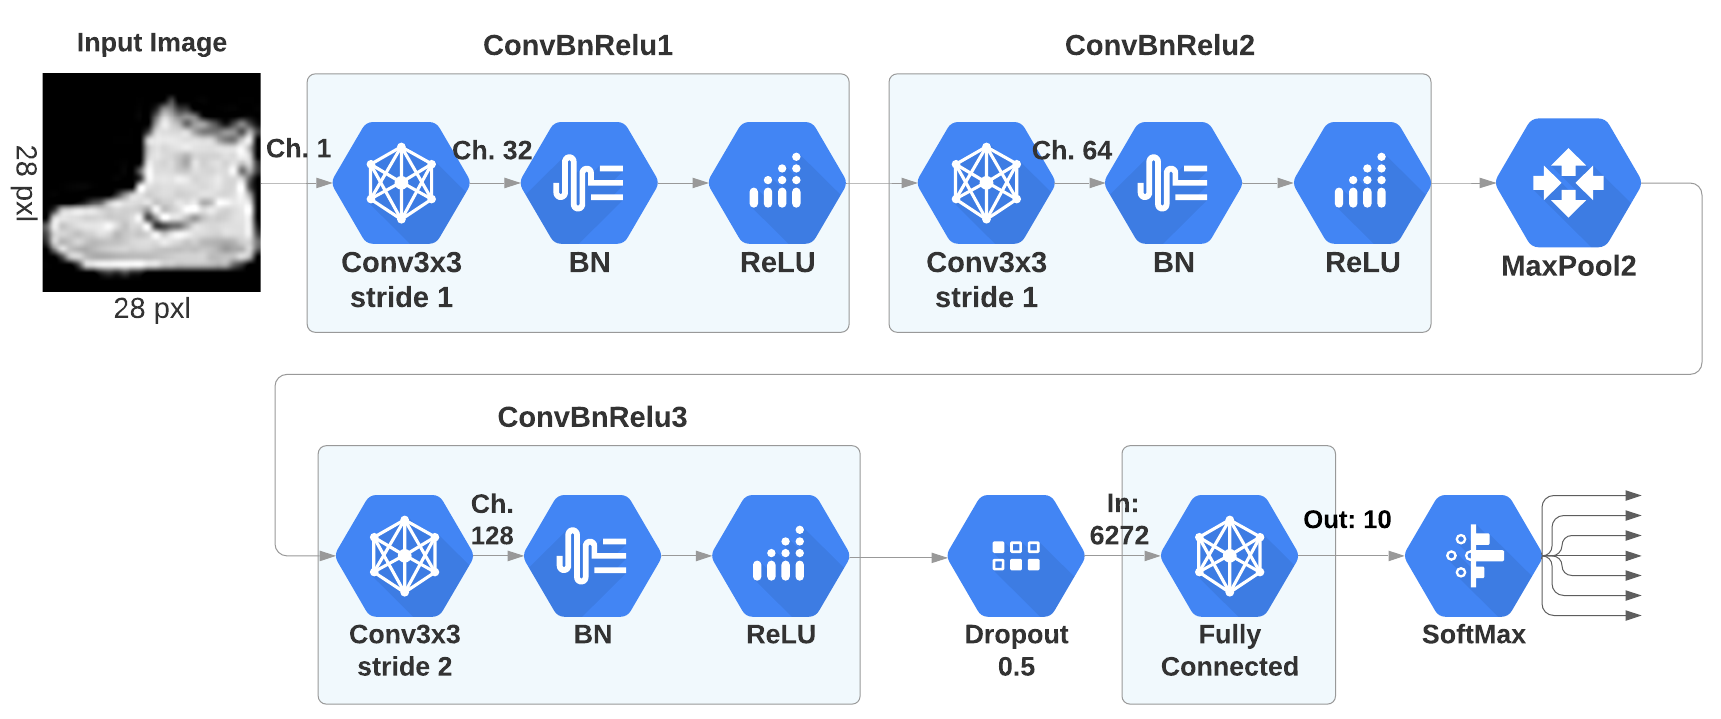

In [ ]:
#@title Dummy input  { form-width: "70%" }
# input_size = (batch_n, img_ch,img_width, img_height)
input_size = (1, 1, 28, 28)  #@param
input = torch.randn(input_size).to(device)#add one extra field to input size for batch_n


## **From LAB1 Task 2:** Count network's parameters and MAC operations

---

A useful function to measure the model's MAC operations and number of parameters.

**TorchInfo insights:**
This tool calculates the Parameters Size as (number_of_parameters*4).
This because each parameter needs 4 Bytes (32bit) to be represented in float32 format.

In [ ]:
def print_summary(net, input_size, verbose=True):
    from torchinfo import summary
    net_info = summary(net, input_size=input_size)
    params = net_info.total_params
    macs = net_info.total_mult_adds
    if verbose: print(net_info)
    return params, macs

# calculate n° parameters and mac operations
params, macs = print_summary(deepcopy(net), input_size) #use deepcopy to avoid graph modifications by hese function calls
# print them
print("\nNetwork's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))


## **From LAB1 Task 3:** Dataset & DataLoaders

---

We use the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), which is a set of 28x28 grayscale images of clothes.

The dataset is stored on the Colab VM in the `/data/fashionmnist` directory by default.



In [ ]:
def get_data_loaders(train_batch_size=128, val_batch_size=128, path='./data/fashionmnist',verbose=False):
    # 1. define data transformations
    fashion_mnist = datasets.FashionMNIST(download=True, train=True, root=path).train_data.float()
    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])

    # 2. Load train/valid datasets
    train_dataset = datasets.FashionMNIST(download=False, root=path, transform=data_transform, train=True)
    valid_dataset = datasets.FashionMNIST(download=False, root=path, transform=data_transform, train=False)

    # 3. define dataloaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=val_batch_size,
        shuffle=False)

    # Optional: count how many images we have in each set
    train_dataset_size = len(train_dataset)
    valid_dataset_size = len(valid_dataset)
    if verbose: print('Dataset size:\nTraining images %d,\nValidation images %d' % (train_dataset_size, valid_dataset_size))

    return train_loader, valid_loader

train_loader, val_loader = get_data_loaders(verbose=True)


## **From LAB1 Task 4:** testing the CNN over the dataset

---



### Accuracy Metric calculation

First we define a function to calculate the accuracy, defined as: `accuracy = num_correct_predictions/total_n_predictions`



In [ ]:
def calculate_accuracy(best_guesses, targets):
    num_correct = torch.eq(targets, best_guesses).sum().item()
    total_guesses = len(targets)
    correct_percentage = num_correct/total_guesses
    return correct_percentage

### Testing Function
The following cell defines a function, `validate,` that runs a network on a dataset and shows the percentage of the dataset that was correctly classified.

In [ ]:
def validate(net, val_loader, loss_function, accuracy_score):
    val_losses = []
    val_accuracy = []

    # set net to evaluating (testing)
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # net forward
            outputs = net(inputs) # this gets the prediction from the network

            # calculate loss
            loss = loss_function(outputs, labels)
            val_losses.append(loss) # append current average training loss to a buffer variable, for plotting learning curve

            # calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            val_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu()))

    average_val_loss = sum(val_losses)/(batch_idx+1)
    average_val_accuracy = sum(val_accuracy)/len(val_loader)
    return average_val_accuracy, average_val_loss


## **From LAB1 Task 5:** Training Loop

In [ ]:
# Move net to gpu:
net.to(device)

# Define loss function
loss_function = nn.CrossEntropyLoss() # cross entropy works well for multi-class problems


def training(net, train_loader, val_loader, loss_function, epochs):    
    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

    # count tot batches
    tot_train_batches = len(train_loader)
    tot_val_batches = len(val_loader)

    # Create lists to store training history
    train_loss_history = []
    train_accuracy_history = []
    # Create lists to store validation history
    val_loss_history = []
    val_accuracy_history = []

    start_ts = time.time()
    # loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        # progress bar (works in Jupyter notebook too!)
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=tot_train_batches)

        # ----------------- TRAINING  -------------------- #
        # set model to training
        net.train()
        
        for batch_idx, data in progress:
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Compute prediction (forward input in the model)
            outputs = net(inputs)
            # Compute prediction error with the loss function
            loss = loss_function(outputs, labels)
            # Backpropagation
            net.zero_grad()
            loss.backward()
            # Optimizer step
            optimizer.step()

            # getting training quality data
            current_loss = loss.item()

            #compute average loss
            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss/(batch_idx+1)
            
            # calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            train_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 
            average_train_accuracy = sum(train_accuracy)/(batch_idx+1)

            # updating progress bar
            progress.set_description("Training Loss: {:.4f}, Accuracy: {:.4f}".format(average_train_loss, average_train_accuracy))
            
            ## DEBUG: stop after one single batch
            # break

        # ----------------- VALIDATION  ----------------- #
        average_val_accuracy, average_val_loss = validate(net, val_loader, loss_function, accuracy_score)
        
        # compute mean accuracy
        average_train_accuracy = sum(train_accuracy)/tot_train_batches

        # print training/validation Accuracy and Loss
        print('Epoch %d/%d' % (epoch+1,epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))
        
        # append current average training loss to a buffer variable, for plotting learning curve later
        train_loss_history.append(average_train_loss)
        val_loss_history.append(average_val_loss)
        train_accuracy_history.append(average_train_accuracy)
        val_accuracy_history.append(average_val_accuracy)

    print('Training time: %.1f seconds' % (time.time()-start_ts))

            
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

# retrain the network (not necessary if you load a pre trained model, as we will do later !)
# _, _, _, _= training(net, train_loader, val_loader, loss_function, epochs)

## **From LAB1 Task 6:** Save/Load the CNN weights


In [ ]:
#@title Training parameters { form-width: "70%" }
model_export_path = "./model/" #@param {type:"string"}
model_name = 'ExampleNet.pth' #@param {type:"string"}
os.makedirs(model_export_path, exist_ok=True)


In [ ]:
def save_net(net,model_path, model_name):
    #Save Pytorch model
    torch.save(net.state_dict(), join(model_path,model_name))

save_net(net,model_export_path, model_name)

In [ ]:
def load_net(net, model_path, model_name, device):
    ''' Load a PyTorch Model '''
    checkpoint_file= join(model_path,model_name)
    # load weights file
    state_dict = torch.load(checkpoint_file, map_location=device)
    # Load weights into the network
    net.load_state_dict(state_dict)
    # to device (cpu or gpu)
    net = CNN().to(device)
    return net

---
---
---

# **LAB03 Starts here !**

---
---
---


# **TASK1:** Load Pre-Trained Model from LAB1

---



Let's download the pre-trained weights for the network.
I already prepared them for you in our [GitHub repo](https://github.com/EEESlab/APAI24-LAB03-DNN-Shrinking-and-Quantization/blob/master/ExampleNet.pth) 🙂
(search for `ExampleNet.pth` file)

In [ ]:
!rm -r APAI24-LAB03-DNN-Shrinking-and-Quantization

!git clone https://github.com/EEESlab/APAI24-LAB03-DNN-Shrinking-and-Quantization

In [ ]:
#@title define path for CNN's pre-trained weights { form-width: "70%" }
pre_trained_path = "./APAI24-LAB03-DNN-Shrinking-and-Quantization/" #@param {type:"string"}
model_name = 'ExampleNet.pth' #@param {type:"string"}


### Load pre-trained weights

In [ ]:
load_net(...........)

Test again the network accuracy, to be sure that you saved/loaded weights correctly.



In [ ]:
# Test over validation dataset
loss_function=nn.CrossEntropyLoss()
average_val_accuracy, average_val_loss = validate(YOUR_NETWORK_HERE, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

**if accuracy ~ 90% : you were successful !!**

# **Task 2:** Reduce Network's MAC operations 

---


Current network has: 
*   n°params: 155.616k
*   MAC: 18.515M

**Task:** Reduce it below 5 MMAC, but keeping accuracy ~90%.

**Solution:**

In this solution we will reduce the number of channels of the convolutional layers, by halving them (depth multiplier = 0.5).

You can explore another 2 ways:
1.   Add or remove layers
2.   Play with the “stride” of che convolutional layers.





## New network with reduced size

In [ ]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ConvBnRelu, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False, padding_mode='zeros')
        self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

class CNN_reduced(nn.Module):
    def __init__(self, n_classes=10):
        super(CNN_reduced, self).__init__()
        # .................

    def forward(self, x):
        # .................
        return output


net_reduced = CNN_reduced().to(device)


Let's see how many MAC operations the new network has...

In [ ]:
params, macs = print_summary(deepcopy(net_reduced), input_size) #use deepcopy to avoid graph modifications by hese function calls
print("\nNetwork's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))


**The New network has 4.66M MAC, which is less than our constrain of 5M !!**

# **TASK3:** Retrain the network and verify validation accuracy ~90%

You can use the same training loop you implemented in LAB1 Task5. 

<u>If you were not able to finish it, now it is you chance to implement it, and we are here to help!</u>

*Tip:* use `nn.CrossEntropyLoss()` as loss



In [ ]:
#@title Training parameters { form-width: "70%" }
epochs = 1 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}

In [ ]:
# Build Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

In [ ]:
# Train the network!
(train_loss_history,
train_accuracy_history, 
val_loss_history, 
val_accuracy_history) = training(YOUR SMALL MODEL HERE, train_loader, val_loader, loss_function, epochs)

# **Task4**: Quantization

We want to quantize the network from a float32 representation to a fixed-point representation (integer). As we studied in class, quantization is a technique that allow us to compress the neural network (i.e., reduce its size) and to accelerate the inference time (float operations vs int operations). We want to quantize the network in an extreme way, from 32 bits to only 2 bits (16x compression !!!). By doing this, we also want 
Output: Quantize the network to 2 bits, except for the first convolutional layer and last FullyConnected layer that must be quantized to 8 bits

We will use QuanLab as tool for quantization. Resources:

* 2021 Class: [Theoretical Lesson Slides: Quantization](https://virtuale.unibo.it/pluginfile.php/1040235/mod_resource/content/1/08_QuantizationPruning.pdf)
* 2021 slides: [Quantlab lesson slides](https://virtuale.unibo.it/pluginfile.php/1049522/mod_resource/content/3/LAB03%20QuantLab.pdf)
* 2021 colab: [Quantlab Hands-on: COLAB](https://colab.research.google.com/drive/12_rof_QeNL_TMU4LSUV-ZFUvgUx0YMng)

***Quick recap on QuantLab (taken from LAB3 colab):***

The computational graph of our network uses floating-point operands, i.e., it is a floating-point computational graph.

As a first step towards quantisation, we need to introduce `Module`s that support PACT/SAWB.
This step is called the **float-to-fake** (F2F) conversion: it introduces linear quantisers into the computational graph, but at the same time continues to operate with floating-point operands.
Therefore, at this stage quantisation is only simulated (i.e., *faked*), and the computational graph is said to be **fake quantised** (FQ).

However, at a later stage it will be possible to apply elementary arithmetic properties and some clever approximation rules to turn the computational graph into a program operating on integer operands and using only hardware-friendly integer operations, i.e., a **true quantised** (TQ) computational graph.
This step is called teh **fake-to-true** (F2T) conversion.


## **1st quantization step: Float-to-fake**

This is the first step for preparing & converting a conventional neural network to the quantized form, which is where “fake quantization” nodes come in (image below: red nodes):

* The role that fake quantization nodes fulfil is to simulate the rounding effect of quantization in the forward pass, as it would occur in actual inference of a quantized network. So we are not converting activation's output 
and the convolutional weights to fixed-point representation (`integer`), we are just adding a "fake quantization" node that simulates the effect of quantization. This allows to keep all parameters stored as float with the real full-precision. 

***Why do we want to keep the original `float32` values?***

* It is mandatory at training time, so that backpropagation still works as usual. A quantized network would have no way to be trained and updated with infinitesimal gradients.

***Why do we want to train a quantized network then ?***

* Frequently, after applying quantization, we must run a few epochs of fine-tuning (called **quantization-aware training**) to adjust for the precision loss introduced by a lower bitwidth.

**Summary:** Fake quantization nodes simulates the quantization effects on weights and output activations just during the forward pass (`input->output`). While during backpropagation (`input<-output`) the fake quantization nodes are not active and the weights and activations retain their original `float32` values.


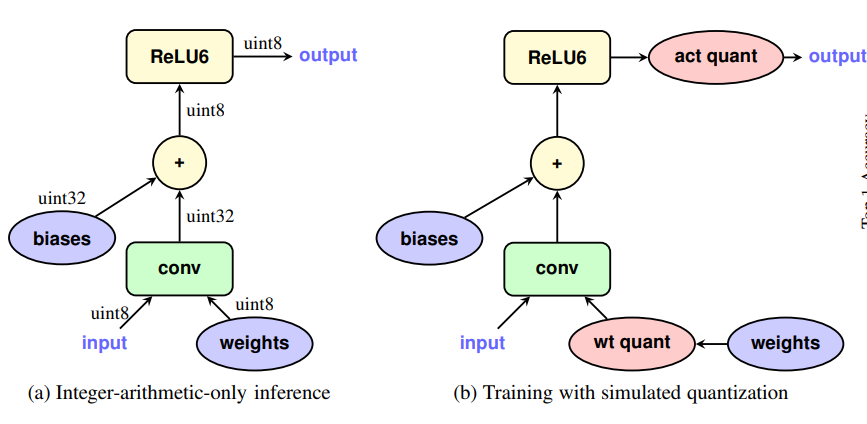

To perform F2F conversion, we must replace standard PyTorch Modules with corresponding FakeQuantized counterparts. 

In Quantlab, we will do so thanks to the so-called quantisation recipes (a quantisation recipe is a function taking in input a floating-point Module and producing an FQ Module).

In [ ]:
#@title float-to-fake (F2F) function {form-width: "30%"}

def all_pact_f2f_recipe(network: nn.Module, name2config: Dict[str, Dict]) -> nn.Module:

    lwg = qlw.LightweightGraph(network)
    name2type = {n.name: n.module.__class__.__name__ for n in lwg.nodes_list}

    # generate lightweight (i.e., atomic) replacement rules
    assert set(name2config.keys()).issubset(set(name2type.keys()))
    type2rule = \
    {
        'Conv2d': qlw.rules.pact.ReplaceConvLinearPACTRule,
        'Linear': qlw.rules.pact.ReplaceConvLinearPACTRule,
        'ReLU':   qlw.rules.pact.ReplaceActPACTRule
    }
    rhos = list(map(lambda n: type2rule[name2type[n]](qlw.rules.NameFilter(n), **name2config[n]), name2config.keys()))

    # boot lightweight editor and apply atomic rules
    lwe = qlw.LightweightEditor(lwg)
    lwe.startup()
    for rho in rhos:
        lwe.set_lwr(rho)
        lwe.apply()
    lwe.shutdown()

    return lwe.graph.net


To simplify the exploration of different quantisation policies, we aim at defining the configurations of quantised nodes in a programmatic way.

We will define a function called `all_pact_create_configs` to create a **quantization configuration**. Then, we can add **patches** to ovveride the default configuration 






---
**ASSIGNMENT TASK:** 

we want to quantize ALL the network to 2 bits, EXCEPT FOR the first conv and last Fully Connected layers, which must be quantized to 8 bits. These two layers can be quantized to a different bitwidth thanks to patches!

---

***Hint:*** to define the quantization bidtwidth, use the `'n_levels'` field, remembering that the quantization levels for `n` bits correspond to `2^n`

In [ ]:
#@title quantization config {form-width: "30%"}

# Definition of "patches". In other words, these are exceptions meant to override the quantization configuration.
patches = \
{
    'ConvBnRelu1.conv1':      {'n_levels': XXXXX},  # FILL-ME: This value is incorrect. Put here the right number
    'fc': {'n_levels': XXXXXX}                      # FILL-ME: This value is incorrect. Put here the right number
}

# create configuration for PACT float-to-fake conversion
def all_pact_create_configs(network: nn.Module, patches: Dict[str, Dict]) -> Dict[str, Dict]:

    lwg = qlw.LightweightGraph(network)
    conv2d_nodes = set([n.name for n in lwg.nodes_list if n.module.__class__.__name__ == 'Conv2d'])
    linear_nodes = set([n.name for n in lwg.nodes_list if n.module.__class__.__name__ == 'Linear'])
    relu_nodes   = set([n.name for n in lwg.nodes_list if n.module.__class__.__name__ == 'ReLU'])
    assert set(patches.keys()).issubset(conv2d_nodes | linear_nodes | relu_nodes)

    # configure convolutional nodes quantization
    conv2d_default = \
    {
        'quantize':   'per_channel',
        'init_clip':  'sawb_asymm',
        'learn_clip': False,
        'symm_wts':   True,
        'tqt':        False,
        'n_levels':   XXXXX # FILL-ME: This value is incorrect. Put here the right number
    }

    conv2d_config = defaultdict(lambda: conv2d_default.copy())
    for n in conv2d_nodes:
        conv2d_config[n].update(patches[n] if n in patches.keys() else {})  # patches have higher priority than default configurations

    # configure linear nodes quantization
    linear_default = \
    {
        'quantize':   'per_layer',
        'init_clip':  'sawb_asymm',
        'learn_clip': False,
        'symm_wts':   True,
        'tqt':        False,
        'n_levels':   XXXXXX # FILL-ME: This value is incorrect. Put here the right number
    }

    linear_config = defaultdict(lambda: linear_default.copy())
    for n in linear_nodes:
        linear_config[n].update(patches[n] if n in patches.keys() else {})  # patches have higher priority than default configurations

    # configure ReLU nodes quantization
    relu_default = \
    {
        'init_clip':  'std',
        'learn_clip': True,
        'nb_std':     3,
        'rounding':   False,
        'tqt':        False,
        'n_levels':   XXXXXX # FILL-ME: This value is incorrect. Put here the right number
    }

    relu_config = defaultdict(lambda: relu_default.copy())
    for n in relu_nodes:
        relu_config[n].update(patches[n] if n in patches.keys() else {})  # patches have higher priority than default configurations

    # create complete quantization configuration
    config = {**conv2d_config, **linear_config, **relu_config}

    return config



Use the function we defined to create a configuration for quantization

In [ ]:
# create configuration, adding ad-hoc patches
name2config = all_pact_create_configs(deepcopy(net), patches)

# apply PACT float-to-fake conversion
pact_network = all_pact_f2f_recipe(deepcopy(net), name2config)
pact_network.to(device=device)
print(pact_network)


We can notice that some modules has been replaced:


---
**ASSIGNMENT TASK:** 

Copy and paste the new names of the following modules: 

*   `Conv2d()` --became--> `.................`
*   `Linear()` --became--> `.................`
*   `ReLU()`   --became--> `.................`
---




## **2nd quantization step: Quantization-aware training (QAT)**

After applying quantization, we must run a few epochs  (just 1 enough in this case)  of fine-tuning, called *quantization-aware training*, to adjust for the precision loss introduced by a lower bitwidth.

* In Quantlab, we define a controller recipe to be a function that takes in input a Module and a description of the hyper-parameters, and returns a controllers that implement the desired training strategy.

In [ ]:
#@title Quantization-aware training controller { form-width: "20%" }
def all_pact_get_controllers(network:         nn.Module,
                            schedule_linear: Dict[int, Union[str, List[str]]],
                            schedule_act:    Dict[int, Union[str, List[str]]],
                            kwargs_linear:   Dict = {},
                            kwargs_act:      Dict = {}) -> Tuple[qa.pact.PACTLinearController, qa.pact.PACTActController]:

    modules_linear    = qa.pact.PACTLinearController.get_modules(network)
    controller_linear = qa.pact.PACTLinearController(modules_linear, schedule_linear, **kwargs_linear)

    modules_act    = qa.pact.PACTActController.get_modules(network)
    controller_act = qa.pact.PACTActController(modules_act, schedule_act, **kwargs_act)

    return controller_linear, controller_act

pact_schedule_linear = \
{
    0: ['verbose_on', 'start']
}

pact_schedule_act = \
{
    0: ['verbose_on', 'start']
}

pact_controller_linear, pact_controller_act = all_pact_get_controllers(pact_network, pact_schedule_linear, pact_schedule_act)

In [ ]:
# Define Loss, optimizer and scheduler for QAT fine-tuning
loss_fn   = nn.CrossEntropyLoss()
optimiser = qa.pact.PACTAdam(pact_network, pact_decay=0.001, lr=0.004)
lr_sched  = optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=250, eta_min=0.00001)  # in this 'LRScheduler', the value of 'T_max' should be set equal to the number of epochs for which you plan to train the network


Let's define the Quantization-Aware Training function:

In [ ]:
def fit_quantised(device:          torch.device,
                  train_loader:    torch.utils.data.DataLoader,
                  valid_loader:    torch.utils.data.DataLoader,
                  network:         nn.Module,
                  qnt_controllers: List[Union[qa.pact.PACTLinearController, qa.pact.PACTActController]],
                  loss_fn:         nn.Module,
                  optimiser:       torch.optim.Optimizer,
                  lr_sched:        torch.optim.lr_scheduler._LRScheduler,
                  n_epochs:        int) -> None:

    for i_epoch in range(0, n_epochs):

        # training pass
        network.train()
        optimiser.zero_grad()

        for qnt_ctrl in qnt_controllers:
            qnt_ctrl.step_pre_training_epoch(i_epoch)  # NOTE: the hyper-parameters of the QAT algorithm could be updated at each epoch

        for i_batch, (x, y_gt_int) in enumerate(train_loader):
            for qnt_ctrl in qnt_controllers:
                qnt_ctrl.step_pre_training_batch()  # NOTE: the hyper-parameters of the QAT algorithm could be updated at each epoch

            x        = x.to(device=device)
            y_gt_int = y_gt_int.to(device=device)

            y_pr       = network(x)
            loss_value = loss_fn(y_pr, y_gt_int)

            loss_value.backward()
            optimiser.step()
            optimiser.zero_grad()

            # calculate training accuracy
            predicted_classes = torch.max(y_pr, 1)[1] # get class from network's prediction
            accuracy = calculate_accuracy(predicted_classes.cpu(), y_gt_int.cpu())

            print("Epoch[{:02d}/{:02d}] | Iteration[{:04d}/{:04d}] - Loss value: {} - Accuracy: {:.3f}".format(i_epoch, n_epochs, i_batch, len(train_loader), loss_value.item(), accuracy))

        lr_sched.step()

        # validation pass
        network.eval()
        correct = 0

        for qnt_ctrl in qnt_controllers:
            qnt_ctrl.step_pre_validation_epoch(i_epoch)  # NOTE: the hyper-parameters of the QAT algorithm could be updated at each epoch

        for x, y_gt_int in valid_loader:

            x        = x.to(device=device)
            y_gt_int = y_gt_int.to(device=device)

            y_pr     = network(x)
            y_pr_int = y_pr.argmax(axis=1)

            correct += torch.sum(y_pr_int == y_gt_int).item()

        print("Epoch[{:02d}/{:02d}] - Validation accuracy: {:6.2f}%".format(i_epoch, n_epochs, 100.0 * correct / len(valid_loader.dataset)))


In [ ]:
#@title Number of quatization-aware training (QAT) epochs { form-width: "70%" }
n_QAT_epochs = 1 #@param {type:"integer"}

Start Quantization-aware fine-tuning !


In [ ]:
# Start Quantization-aware fine-tuning
fit_quantised(device, train_loader, val_loader, pact_network, [pact_controller_linear, pact_controller_act], loss_fn, optimiser, lr_sched, n_QAT_epochs)

In [ ]:
# DEBUG QUANTLAB: check if the quantization has been activated
pact_network.ConvBnRelu1.conv1.started

## **3rd quantization step: Fake-to-true**

At this stage, we drop the "fake-quantization nodes" (the red nodes in the figure) and we transform all parameters to a fixed-point representation, dropping forever the original `float32` values.

For doing so, we must calculate the `min` and `max` input ranges and the `input_eps` (also called *quantum*)

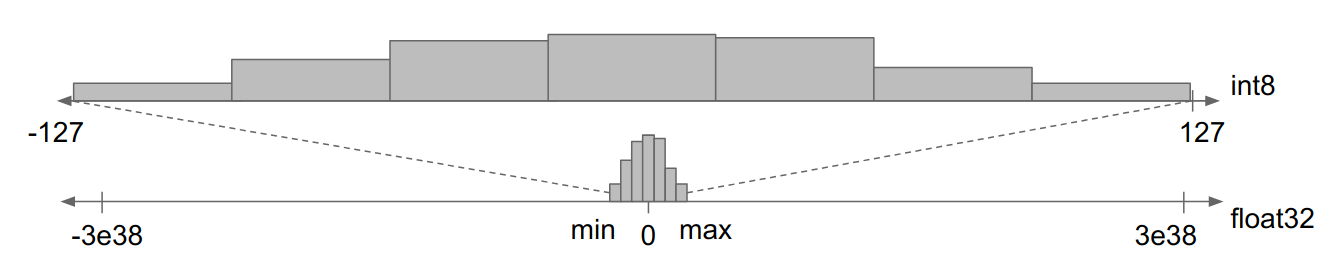

In [ ]:
#@title Calculate input ranges {form-width: "30%"}
import quantlib.algorithms as qa

def get_input_range(data_loader: torch.utils.data.DataLoader) -> Tuple[float, float]:
    """Traverse the available data set to get the empirical range of input pixels."""
    min_ = 0.0
    max_ = 0.0

    for x, _ in data_loader:
        min_ = min(min_, x.min().item())
        max_ = max(max_, x.max().item())

    return min_, max_


def add_quantisation_transform(data_loader: torch.utils.data.DataLoader, n_levels: int, min_: float, max_: float) -> float:

    quantiser = qa.pact.PACTAsymmetricAct(n_levels=n_levels, symm=True, learn_clip=False, init_clip='max', act_kind='identity')

    clip_lo, clip_hi       = qa.pact.util.almost_symm_quant(torch.Tensor([max(abs(min_), abs(max_))]), n_levels)
    quantiser.clip_lo.data = clip_lo
    quantiser.clip_hi.data = clip_hi

    quantiser.started |= True

    transform_list  = []
    transform_list += [data_loader.dataset.transform]
    transform_list += [quantiser]
    transform_list += [transforms.Lambda(lambda x: x / quantiser.get_eps())]

    data_loader.dataset.transform = transforms.Compose(transform_list)

    return quantiser.get_eps()


In [ ]:
#@title Calculate input eps {form-width: "30%"}

# each pixel of grayscale images has the [0,255] range
n_input_levels = 2**8
# get min max input range
min_, max_     = get_input_range(val_loader)
# calculate input eps
val_loader_true_quant = deepcopy(val_loader)
input_eps = add_quantisation_transform(val_loader_true_quant, n_input_levels, min_, max_)

In [ ]:
#@title fake-to-true (F2T) function {form-width: "30%"}

import quantlib.editing.fx as qfx


def f2t_convert(dataloader: torch.utils.data.DataLoader,
                input_eps:  float,
                network:    nn.Module) -> nn.Module:

    network.eval()
    network = network.to(device=torch.device('cpu'))
    x, _ = dataloader.dataset.__getitem__(0)

    x    = x.unsqueeze(0).to(device=torch.device('cpu'))

    fake2true_converter = qfx.passes.pact.IntegerizePACTNetPass(shape_in=x.shape, eps_in=input_eps, D=2**19)

    return fake2true_converter(network)


In [ ]:
tq_pact_network = f2t_convert(val_loader_true_quant, input_eps, deepcopy(pact_network))

A sanity check: we compare the predictions of the fully-integerised program with the ground truth to verify that they are coherent.


In [ ]:
#@title Sanity check {form-width: "30%"}
import random
random_idx = random.randrange(0, len(val_loader.dataset))
# pick random image from dataset
x, y_gt_int = val_loader.dataset.__getitem__(random_idx)
x = x.unsqueeze(0)
net.to('cpu')
# prediction original float32 network
y_pr_float = net(x)
y_pr_float_max = y_pr_float.argmax(axis=1)

x, y_gt_int = val_loader_true_quant.dataset.__getitem__(random_idx)
x = x.unsqueeze(0)
# prediction quantized network
y_pr = tq_pact_network(x)
y_pr_int = y_pr.argmax(axis=1)

print("True Quantized: \t\tTrue: {} - Predicted: {}".format(int(y_gt_int), y_pr_int.item()))
print("FLOAT32:\tTrue: {} - Predicted: {}\n".format(int(y_gt_int), y_pr_float_max.item()))

net.to(device)
tq_pact_network.to(device)

# print(y_pr, y_pr)
# print(y_pr_float)

let's verify that the accuracy didn't drop between FLOAT32 and TrueQuantized stages.

In [ ]:
# Test the NON QUANTIZED network over validation dataset
average_val_accuracy, average_val_loss = validate(YOUR_NETWORK_HERE, val_loader, loss_function, accuracy_score)
# Print valid statistics
print('FLOAT32 Validation Accuracy: %.4f' % (average_val_accuracy))

In [ ]:
# Test the QUANTIZED network over validation dataset
average_val_accuracy, average_val_loss = validate(YOUR_NETWORK_HERE, val_loader_true_quant, loss_function, accuracy_score)
# Print valid statistics
print('INT2 Validation Accuracy: %.4f' % (average_val_accuracy))

# **Task5:** Export to ONNX format


The trained networks can be exported in [**ONNX (*Open Neural Network eXchange*)**)](https://github.com/onnx/onnx) format for  deployment tools. This format is recognized as the official format to export a deep neural network. This format stores all the necessary elements to reload a network:
* topology: number of layers, how they are linked and their type;
* layer structure: stride, filter dimension, channels, etc..
* parameters: for each layer, all the weights and numeric parameters are stored.

**How to use:** To see how the model looks like, the following cells will 
1) trigger a download to your local machine, and 2)  open a frame into Colab to a tool called [Netron](https://netron.app). This tool that can be used to visualize it: just drag the ONNX file and drop it on top of the Netron frame!


**IMPORTANT:** now we are going to visualize two networks: 1. the original float32 network (so, the non-quantized one), and 2) the quantized one.


### **1. Export the original Float32 model (non-quantized!)**

Export the ONNX file of the NON-quantized network.


In [ ]:
net.eval()
torch.onnx.export(YOUR_NETWORK_HERE, input, 'ExampleNet_Float32.onnx')

Download the ONNX file of the quantized network on your local computer.

In [ ]:
from google.colab import files
files.download('ExampleNet_Float32.onnx')

Open Netron and visualize the non-quantized network, named: `ExampleNet_Float32`, by loading it to Netron.
That is, accept cookies, and "open model" by dragging and dropping the file you downloaded.

In [ ]:
#@title Open Netron {form-width: "30%"}
import urllib
from IPython.display import IFrame
url = urllib.parse.quote("https://netron.app/", safe=':/?=&')
IFrame(url, width=800, height=600)

---
**ASSIGNMENT TASK:** 

Use Netron to analyze the ONNX file of the original NON QUANTIZED network and answer the following question:

* What's the data format of the convolutional layers' weights? 
* Is the decial part of the convolutional weights !=0 ?  Paste here the value of a single weight as an example.
* What's the kernel size of all the convolutions?

---

***Hints***:
* Examples of possible data formats: `int8`, `int16`, `int32`, `int64`, `float16`, `float32`
* Example: the decimal part of `1234.567` is `567`

### **2. Export the Quantized model**

In [ ]:
#@title Quantlab's export function {form-width: "30%"}
def export_network(data_loader: torch.utils.data.DataLoader,
                   input_eps:   float,
                   network:     nn.Module,
                   filename:    str,
                   dir_export:  os.PathLike) -> None:

    network.eval()

    x, _ = data_loader.dataset.__getitem__(random.randrange(0, len(data_loader.dataset)))
    x = x.unsqueeze(0)

    qb.dory.export_net(network,
                       name=filename,
                       out_dir=dir_export,
                       eps_in=input_eps,
                       integerize=False,
                       D=2**19,
                       in_data=x)

Export the ONNX file of the quantized network.


In [ ]:
export_network(val_loader_true_quant, input_eps, YOUR_NETWORK_HERE, 'ExampleNet_Quantized', model_export_path)

Download the ONNX file of the quantized network on your local computer.


In [ ]:
from google.colab import files
files.download(join(model_export_path,'ExampleNet_Quantized_ql_integerized.onnx'))

Open Netron and visualize the quantized network, named: `ExampleNet_Quantized_ql_integerized.onnx`


In [ ]:
#@title Open Netron {form-width: "30%"}

import urllib
from IPython.display import IFrame
url = urllib.parse.quote("https://netron.app/", safe=':/?=&')
IFrame(url, width=800, height=600) # you can resize the Netron frame size here!

---
**ASSIGNMENT TASK:** 

Use Netron to analyze the ONNX file of the QUANTIZED network and answer the following question:

* What's the size of the input image?
* What's the data format of all the convolutional weights? 
* Is the decimal part of the convolutional weights !=0 ? . Paste here the value of a single weight as an example.
* What's the quantization bitwidth of the `ConvBnRelu1` convolutional weights? (look for `weight_bits`)
* What's the quantization bitwidth of the `ConvBnRelu2` convolutional weights? (look for `weight_bits`)
* What's the kernel size of all the convolutions?
---

***Hints***:
* Examples of possible data formats: `int8`, `int16`, `int32`, `int64`, `float16`, `float32`
* Example: the decimal part of `1234.567` is `567`